In [13]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text as text
import pandas as pd

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 462 kB 63.5 MB/s 


In [14]:
df = pd.read_csv("clean_spam.csv")

In [15]:
df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
df.rename(columns={'v1': 'Category',
                   'v2': 'Message'},
          inplace=True, errors='raise')

In [17]:
df['Category'].value_counts()

ham     4473
spam     478
Name: Category, dtype: int64

## Downsampling

In [19]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']

In [20]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced['Category'].value_counts()

ham     478
spam    478
Name: Category, dtype: int64

## Numerical Encoding

In [21]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.sample(5)

,Category,Message,spam
3396,ham,This is my number by vivek..,0
1615,ham,I couldn't say no as he is a dying man and I f...,0
2328,ham,Ok lor...,0
4004,ham,This weekend is fine (an excuse not to do too ...,0
730,ham,"He has lots of used ones babe, but the model d...",0


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['spam'], test_size=0.2, random_state=42, shuffle=True, stratify=df['spam'])

## BERT

In [23]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [24]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [25]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [26]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=2, batch_size = 32)

Epoch 1/2
124/124 [==============================] - 1836s 15s/step - loss: 0.3012 - accuracy: 0.8947 - precision: 0.0270 - recall: 0.0026
Epoch 2/2
120/124 [============================>.] - ETA: 58s - loss: 0.2216 - accuracy: 0.9062 - precision: 0.6667 - recall: 0.0645 

In [28]:
y_predicted = model.predict(X_test)
y_predicted2 = y_predicted.flatten()

import numpy as np

y_predicted2 = np.where(y_predicted2 > 0.5, 1, 0)
y_predicted2[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-things 0.0.1 requires matplotlib>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


              precision    recall  f1-score   support

           0       0.91      1.00      0.95       895
           1       0.82      0.09      0.17        96

    accuracy                           0.91       991
   macro avg       0.86      0.55      0.56       991
weighted avg       0.90      0.91      0.88       991

Normalized confusion matrix


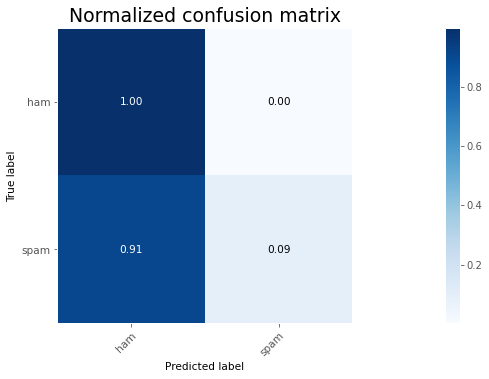

In [30]:
!pip install ml_things
!pip install matplotlib==3.1.3
from sklearn.metrics import classification_report, accuracy_score
from ml_things import plot_dict, plot_confusion_matrix, fix_text

# Create the evaluation report.
######## DELETED ######## -> evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
true_labels = y_test
predictions_labels = y_predicted2
evaluation_report = classification_report(true_labels, predictions_labels)

# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
labels_ids = {'ham': 0, 'spam': 1}
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );